<div align="right"><i>Peter Norvig<br>March 2019</i></div>

# Pairing Socks

[Bram Cohen](https://en.wikipedia.org/wiki/Bram_Cohen) posed a problem that I'll restate thusly:

> *You have N pairs of socks, all different, in the dryer. 
You pull random socks out one-by-one, placing each sock in one of C possible places on the countertop. 
If the latest sock pairs with another on the countertop, you put the pair away in a drawer. We can ask:*
1. *What's the probability that you will pair up all 2N socks before you run out of the C places?*
2. *For a given N, what is the minimum C to have a 50% chance?*
3. *A 100% chance?*

The third question is easy to solve analytically: to be 100% certain of pairing up N pairs, we would need N + 1 countertop spaces, because it is possible that the first N socks are all different, but the next one will always pair with one of the others.
How about the other questions?
- Can I come up with a mathematical formula? **No.**
- Could I calculate an exact answer? **Only for small N.** Enumerating all permutations of socks would take *O*((2N)!), but since I don't care *which* sock is next, only whether it is a match/non-match, I could get that down to *O*(2<sup>(2N)</sup>), but that's still bad.
- Could I do a simulation? **Yes.** And since we're mostly interested in events with probability around 50%, a simulation with, say, 1000 trials is likely to give very good approximations. If we were investigating events with probability 0.0001, we'd need many more trials.

# Sock Pairing Simulation



In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import random
from statistics import mean
from functools import lru_cache

In [2]:
def pair_socks(C:int, socks:list) -> bool:
    """Can we pair up this sock ordering using a countertop of size C?"""
    countertop = []
    while socks and len(countertop) < C:
        s = socks.pop()
        countertop.remove(s) if s in countertop else countertop.append(s)
    return not socks

def random_socks(N):
    """A random ordering of N pairs of socks."""
    socks = 2 * list(range(N))
    random.shuffle(socks)
    return socks

@lru_cache(None)
def P(N, C, trials=1000) -> float: 
    """Estimated probability of pairing up all N pairs on a countertop of size C."""
    return mean(pair_socks(C, random_socks(N)) for _ in range(trials))

def minimum_C(N, p) -> int: 
    """Minimum countertop size needed to have probability `p` of pairing up all socks."""
    return next(C for C in range(N // 2, 3*N) if P(N, C) > p)

First, we can use `minimum_C` to find the countertop size necessary to give a 50% chance of pairing up all the socks, for various values of *N*. We see that the relation is very nearly linear, and the slope is a little more than 1/2:

Slope = 0.52


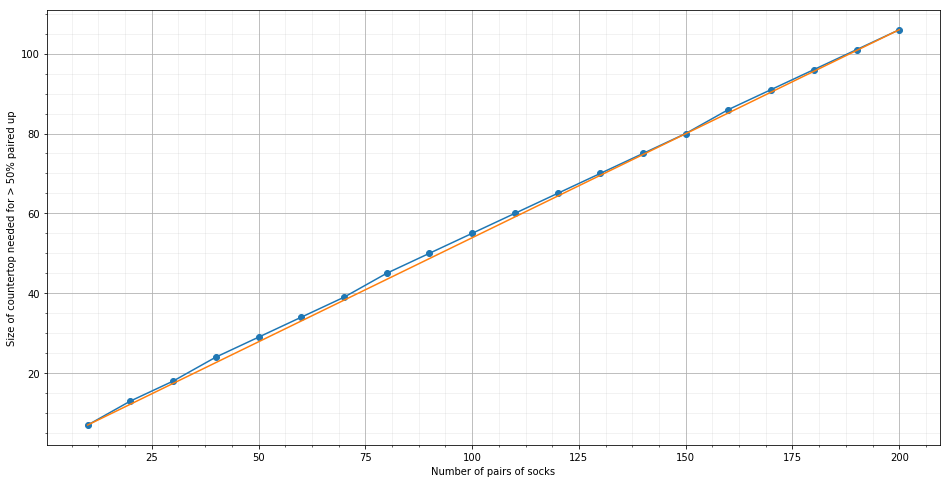

In [3]:
def fig(xlabel, ylabel):
    """Set up a figure."""
    plt.figure(figsize=(16,8)); plt.xlabel(xlabel); plt.ylabel(ylabel)
    plt.minorticks_on()
    plt.grid(b=True, which='major')
    plt.grid(b=True, which='minor', alpha=0.2)
    
def plotC(Ns=range(10, 201, 10)):
    fig('Number of pairs of socks', 'Size of countertop needed for > 50% paired up')
    X = list(Ns)
    Y = [minimum_C(N, 0.5) for N in Ns]
    plt.plot(X, Y, 'o-')
    plt.plot([X[0], X[-1]], [Y[0], Y[-1]])
    print('Slope =', round(extent(Y) / extent(X), 2))
    
def extent(X): return max(X) - min(X)
    
plotC()

Now, for various numbers of pairs of socks ***N***, plot the probability `P(N, C)` of being able to pair up all the socks:

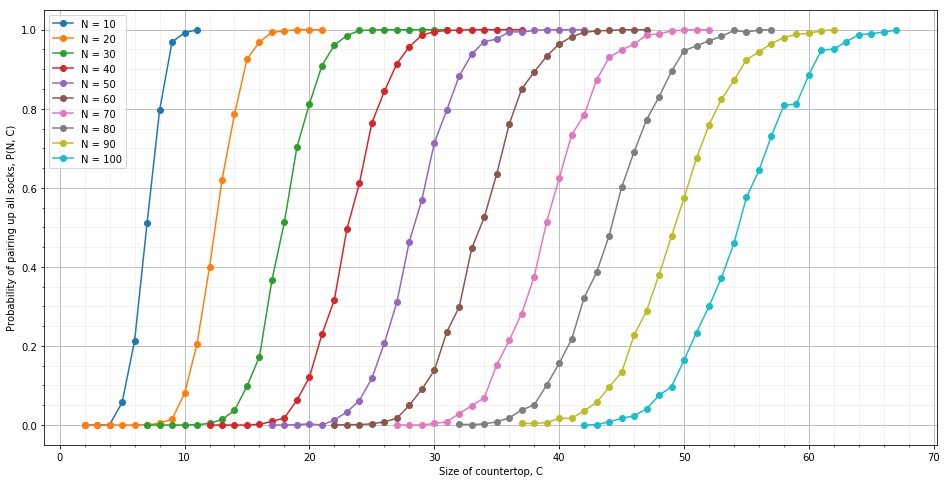

In [4]:
def plotP(Ns=range(10, 101, 10)):
    fig('Size of countertop, C', 'Probability of pairing up all socks, P(N, C)')
    for N in Ns:
        X = range(max(2, N // 2 - 8), min(N + 2, N // 2 + 18))
        plt.plot(X, [P(N, C) for C in X], 'o-', label='N = {}'.format(N))
    plt.legend()
        
plotP()

# Exact Probabilities

I said that I could calculate the probability exactly for small values of ***N***. Let's do that. `Pexact` will call `pair_socks` once for each posssible permutation of the socks, and will use `fractions.Fraction` to get an exact rational number as the probability. This gives us a precise answer, and serves as a check on the inexact function `P`.

In [5]:
from fractions import Fraction
from itertools import permutations

@lru_cache(None)
def Pexact(N, C) -> float: 
    """Exact probability of pairing up all N pairs on a countertop of size C."""
    return mean(Fraction(pair_socks(C, list(socks))) 
                for socks in permutations(list(range(N)) * 2))

In [6]:
N, C = 5, 4
{'1000 trials': P(N, C, trials=1000), 
 '10,0000 trials': P(N, C, trials=10000), 
 'exact': Pexact(N, C),
 'exact as decimal': float(Pexact(N, C))}

{'1000 trials': 0.487,
 '10,0000 trials': 0.464,
 'exact': Fraction(7, 15),
 'exact as decimal': 0.4666666666666667}

We see that the `P` estimate with 1000 trials is not too bad, and with 10,000 trials it is much better.